In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/Voxel_Grid_classifier/

/content/gdrive/MyDrive/Voxel_Grid_classifier


In [ ]:
import torch
import torch.nn as nn
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.multiprocessing as mp
import gzip
from torch.utils.data import random_split
from torchsummary import summary

In [ ]:


class SimplerCNN3D(nn.Module):
    def __init__(self, num_classes):
        super(SimplerCNN3D, self).__init__()

        self.conv1 = nn.Conv3d(1, 32, kernel_size=5, stride=2, padding=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(32, 64, kernel_size=5, stride=2, padding=2)
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveMaxPool3d((1, 1, 1))
        self.fc = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Specify the input shape
input_shape = (1, 60, 60, 60)

In [ ]:
# Create an instance of the model
model2 = SimplerCNN3D(num_classes=10)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

# Print the model summary to get the number of parameters
summary(model2, (1, 60, 60, 60))  # Pass the dummy input shape directly

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 30, 30, 30]           4,032
              ReLU-2       [-1, 32, 30, 30, 30]               0
            Conv3d-3       [-1, 64, 15, 15, 15]         256,064
              ReLU-4       [-1, 64, 15, 15, 15]               0
 AdaptiveMaxPool3d-5          [-1, 64, 1, 1, 1]               0
            Linear-6                   [-1, 10]             650
Total params: 260,746
Trainable params: 260,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.82
Forward/backward pass size (MB): 16.48
Params size (MB): 0.99
Estimated Total Size (MB): 18.30
----------------------------------------------------------------


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
folder_path=%pwd

In [ ]:
file_path=folder_path+ r"/Data/Transformed_Data/Transform_2/Train_Set"

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = os.listdir(folder_path)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        with gzip.open(file_path, 'rb') as f:
            loaded_data = torch.load(f, map_location=torch.device('cpu'))

        data = loaded_data[0]
        label = loaded_data[1]

        # Perform any necessary preprocessing on the data and label
        # ...

        return data, label

In [ ]:
dataset=CustomDataset(file_path)

In [ ]:
# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training, 20% for validation
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
batch_size = 40 # Adjust the batch size according to your memory capacity
num_workers= 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
%cd /content/gdrive/MyDrive/Voxel_Grid_classifier/Model_2

/content/gdrive/MyDrive/Voxel_Grid_classifier/Model_2


Epoch [1/100], Train Batch [40/74], Loss: 1.5784
Epoch [1/100], Validation Loss: 0.9904, Validation Accuracy: 69.74%
Epoch [2/100], Train Batch [40/74], Loss: 0.5104
Epoch [2/100], Validation Loss: 0.6109, Validation Accuracy: 80.60%
Epoch [3/100], Train Batch [40/74], Loss: 0.3708
Epoch [3/100], Validation Loss: 0.4990, Validation Accuracy: 82.90%
Epoch [4/100], Train Batch [40/74], Loss: 0.1447
Epoch [4/100], Validation Loss: 0.4454, Validation Accuracy: 86.30%
Epoch [5/100], Train Batch [40/74], Loss: 0.2815
Epoch [5/100], Validation Loss: 0.3887, Validation Accuracy: 87.11%
Epoch [6/100], Train Batch [40/74], Loss: 0.2389
Epoch [6/100], Validation Loss: 0.3375, Validation Accuracy: 89.42%
Epoch [7/100], Train Batch [40/74], Loss: 0.0839
Epoch [7/100], Validation Loss: 0.4405, Validation Accuracy: 87.25%
Epoch [8/100], Train Batch [40/74], Loss: 0.1557
Epoch [8/100], Validation Loss: 0.3472, Validation Accuracy: 88.87%
Epoch [9/100], Train Batch [40/74], Loss: 0.0634
Epoch [9/100], 

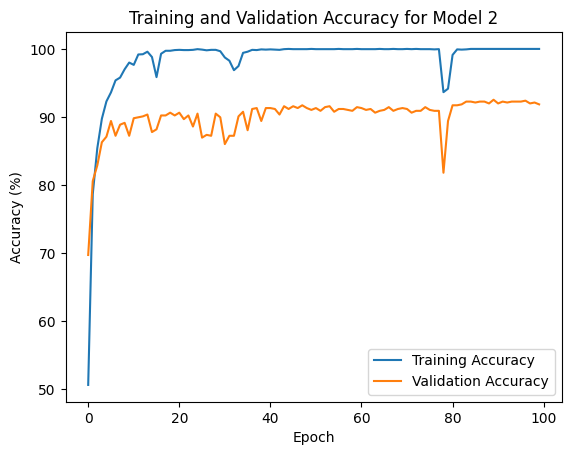

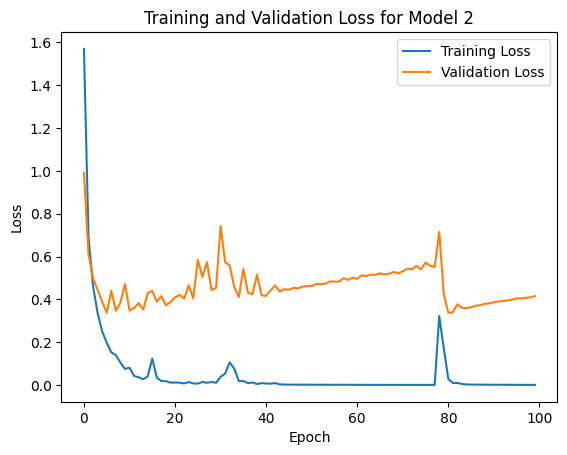

In [ ]:
import torch

num_epochs = 100
model2 = model2.to(device)

# Train your model
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

best_val_loss = float('inf')
patience = 7  # Number of epochs to wait for validation loss improvement
no_improvement_count = 0
convergence_epochs = 0
convergence_threshold = 0.5

for epoch in range(num_epochs):
    # Training
    model2.train()
    epoch_train_loss = 0
    epoch_train_total = 0
    epoch_train_correct = 0

    for batch_idx, (data, label) in enumerate(train_dataloader):
        # Move the data and labels to the device
        data = data.to(device)
        label = label.to(device)

        # Convert the data and model's weight tensor to Double
        data = data.unsqueeze(1)
        data = data.double()
        model2.double()

        # Forward pass
        outputs = model2(data)

        # Compute the loss
        loss = criterion(outputs, label)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        epoch_train_total += label.size(0)
        epoch_train_correct += (predicted == label).sum().item()

        # Print training progress
        if (batch_idx + 1) % batch_size == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Batch [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Compute average training loss and accuracy
    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy = 100 * epoch_train_correct / epoch_train_total

    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)

    # Validation
    model2.eval()
    epoch_val_loss = 0
    epoch_val_total = 0
    epoch_val_correct = 0

    with torch.no_grad():
        for data, label in val_dataloader:
            # Move the data and labels to the device
            data = data.to(device)
            label = label.to(device)

            # Convert the data and model's weight tensor to Double
            data = data.unsqueeze(1)
            data = data.double()
            model2.double()

            # Forward pass
            outputs = model2(data)

            # Compute the validation loss
            epoch_val_loss += criterion(outputs, label).item()

            # Compute the accuracy
            _, predicted = torch.max(outputs.data, 1)
            epoch_val_total += label.size(0)
            epoch_val_correct += (predicted == label).sum().item()

    # Compute average validation loss and accuracy
    epoch_val_loss /= len(val_dataloader)
    epoch_val_accuracy = 100 * epoch_val_correct / epoch_val_total

    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)

    # Print validation results
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")

    # Check for convergence
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Check for convergence based on validation

torch.save(model2, 'model2_split.pth')
torch.save(model2.state_dict(), 'trained_model_split.pth')

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy for Model 2')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Model 2')
plt.legend()
plt.show()


Model 1